In [14]:
import numpy as np
import os
import copy
import time
import pickle
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In this code we implement Federated Learning. We have chosen MLP network for our local models with these defined parameters:
* **epochs**: number of gloabal training round
* **num_users**: number of all users
* **frac**: fraction of active users for learning process
* **local_ep**: number of local training round
* **lr**: the amount of learning rate in back-propagtion of MLP model
* **stopping_rounds**: the number of early stopping rounds.

In [15]:
#@title Learning Fields 
epochs = 10 #@param{type:"slider"}
num_users=100 #@param
frac=0.1 #@param
local_ep=10#@param{type:"slider"}
lr=0.01 #@param
gpu=True#@param{type:"boolean"}
stopping_rounds=10#@param

First We need a function to devide our dataset to number of users.

In [16]:
def mnist_iid(dataset, num_users):
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


There is also an abstract class object for data spiliting. In this class we change our dataset to Pytorch tensors to working easily.

In [17]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

LocalUpdate class is defined for the operation of back propagating and learning on local models. 
In this class we have some functions as listed below:


*   **train_val_test:** Returns splitted sets of train, validation and test with rates of (80,10,10)
*   **update_weights:** Updates local model weights in order to train
*   **inference:** Evalutes local model in each round and returns accuracy and loss scores



In [18]:
class LocalUpdate(object):
    def __init__(self, gpu, lr, local_ep, dataset, idxs):
        self.gpu = gpu
        self.lr = lr
        self.local_ep = local_ep
        self.trainloader, self.validloader, self.testloader = self.train_val_test(
            dataset, list(idxs))
        self.device = 'cuda' if gpu else 'cpu'
        # Default criterion set to NLL loss function
        self.criterion = nn.NLLLoss().to(self.device)

    def train_val_test(self, dataset, idxs):

        # split indexes for train, validation, and test (80, 10, 10)
        idxs_train = idxs[:int(0.8*len(idxs))]
        idxs_val = idxs[int(0.8*len(idxs)):int(0.9*len(idxs))]
        idxs_test = idxs[int(0.9*len(idxs)):]

        trainloader = DataLoader(DatasetSplit(dataset, idxs_train),
                                 batch_size=10, shuffle=True)
        validloader = DataLoader(DatasetSplit(dataset, idxs_val),
                                 batch_size=int(len(idxs_val)/10), shuffle=False)
        testloader = DataLoader(DatasetSplit(dataset, idxs_test),
                                batch_size=int(len(idxs_test)/10), shuffle=False)
        return trainloader, validloader, testloader

    def update_weights(self, model, global_round):
        # Set mode to train model
        model.train()
        epoch_loss = []

        # Set optimizer for the local updates
        optimizer = torch.optim.SGD(model.parameters(), lr=self.lr,
                                    momentum=0.5)

        for iter in range(self.local_ep):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.trainloader):
                images, labels = images.to(self.device), labels.to(self.device)

                model.zero_grad()
                log_probs = model(images)
                loss = self.criterion(log_probs, labels)
                loss.backward()
                optimizer.step()

                if batch_idx % 100 == 0:
                    print('| Global Round : {} | Local Epoch : {} |\tLoss: {:.6f}'.format(
                        global_round, iter, loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return model.state_dict(), sum(epoch_loss) / len(epoch_loss)

    def inference(self, model):
        model.eval()
        loss, total, correct = 0.0, 0.0, 0.0

        for batch_idx, (images, labels) in enumerate(self.testloader):
            images, labels = images.to(self.device), labels.to(self.device)

            # Inference
            outputs = model(images)
            batch_loss = self.criterion(outputs, labels)
            loss += batch_loss.item()

            # Prediction
            _, pred_labels = torch.max(outputs, 1)
            pred_labels = pred_labels.view(-1)
            correct += torch.sum(torch.eq(pred_labels, labels)).item()
            total += len(labels)

        accuracy = correct/total
        return accuracy, loss


In this function we calculate accuracy and loss scores of test set:

In [19]:
def test_inference(gpu, model, test_dataset):
    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    device = 'cuda' if gpu else 'cpu'
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    return accuracy, loss


And there is a function to return splited train, test and user_group sets.

In [20]:
def get_dataset():
    data_dir = '../data/mnist/'

    apply_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

    train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                    transform=apply_transform)

    test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                    transform=apply_transform)

    user_groups = mnist_iid(train_dataset, num_users)

    return train_dataset, test_dataset, user_groups


MLP Class object is a model class for our local servers to learn.In this class, we define a function for doing forward operation between layers.It passes input from input layer to hidden layers and finally get softmax output of it.

In [21]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return self.softmax(x)

Average_weights claculate the average of our MLP network weights.

In [22]:
def average_weights(w):
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

---------------------------------------------------------------------------
Let's start process of learning. First we set device (Gpu or Cpu) and download MNIST dataset and fix MLP local model on our device.

In [23]:
#set device
if gpu:
    torch.cuda.set_device(0)
device = 'cuda' if gpu else 'cpu'

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset()

#define local model
img_size = train_dataset[0][0].shape
len_in = 1
for x in img_size:
    len_in *= x
    global_model = MLP(dim_in=len_in, dim_hidden=64,
                        dim_out=10)
global_model.to(device)
global_model.train()
print(global_model)

# copy weights
global_weights = global_model.state_dict()

MLP(
  (layer_input): Linear(in_features=784, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


For the second step we need to train the model for epoch number round with local_ep number on each local model.

In [24]:
start_time = time.time()

# Training
train_loss, train_accuracy = [], []
val_acc_list, net_list = [], []
cv_loss, cv_acc = [], []
print_every = 2
val_loss_pre, counter = 0, 0

for epoch in tqdm(range(epochs)):
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {epoch+1} |\n')

    global_model.train()
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace=False)

    for idx in idxs_users:
        local_model = LocalUpdate(gpu, lr, local_ep, dataset=train_dataset,
                                  idxs=user_groups[idx])
        w, loss = local_model.update_weights(
            model=copy.deepcopy(global_model), global_round=epoch)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

    # update global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)

    # Calculate avg training accuracy over all users at every epoch
    list_acc, list_loss = [], []
    global_model.eval()
    for c in range(num_users):
        local_model = LocalUpdate(gpu, lr, local_ep, dataset=train_dataset,
                                  idxs=user_groups[idx])
        acc, loss = local_model.inference(model=global_model)
        list_acc.append(acc)
        list_loss.append(loss)
    train_accuracy.append(sum(list_acc)/len(list_acc))

    # print global training loss after every 'i' rounds
    if (epoch+1) % print_every == 0:
        print(f' \nAvg Training Stats after {epoch+1} global rounds:')
        print(f'Training Loss : {np.mean(np.array(train_loss))}')
        print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))
        
print('\n Total Run Time: {0:0.4f}'.format(time.time()-start_time))

  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

| Global Round : 0 | Local Epoch : 0 |	Loss: -0.099587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


| Global Round : 0 | Local Epoch : 1 |	Loss: -0.119704
| Global Round : 0 | Local Epoch : 2 |	Loss: -0.120910
| Global Round : 0 | Local Epoch : 3 |	Loss: -0.181820
| Global Round : 0 | Local Epoch : 4 |	Loss: -0.309290
| Global Round : 0 | Local Epoch : 5 |	Loss: -0.385122
| Global Round : 0 | Local Epoch : 6 |	Loss: -0.687171
| Global Round : 0 | Local Epoch : 7 |	Loss: -0.698846
| Global Round : 0 | Local Epoch : 8 |	Loss: -0.348694
| Global Round : 0 | Local Epoch : 9 |	Loss: -0.558082
| Global Round : 0 | Local Epoch : 0 |	Loss: -0.098470
| Global Round : 0 | Local Epoch : 1 |	Loss: -0.115897
| Global Round : 0 | Local Epoch : 2 |	Loss: -0.132431
| Global Round : 0 | Local Epoch : 3 |	Loss: -0.293838
| Global Round : 0 | Local Epoch : 4 |	Loss: -0.393425
| Global Round : 0 | Local Epoch : 5 |	Loss: -0.407358
| Global Round : 0 | Local Epoch : 6 |	Loss: -0.345525
| Global Round : 0 | Local Epoch : 7 |	Loss: -0.502960
| Global Round : 0 | Local Epoch : 8 |	Loss: -0.538165
| Global R

 10%|█         | 1/10 [00:20<03:08, 20.92s/it]


 | Global Training Round : 2 |

| Global Round : 1 | Local Epoch : 0 |	Loss: -0.657250
| Global Round : 1 | Local Epoch : 1 |	Loss: -0.494758
| Global Round : 1 | Local Epoch : 2 |	Loss: -0.354254
| Global Round : 1 | Local Epoch : 3 |	Loss: -0.710478
| Global Round : 1 | Local Epoch : 4 |	Loss: -0.504867
| Global Round : 1 | Local Epoch : 5 |	Loss: -0.586802
| Global Round : 1 | Local Epoch : 6 |	Loss: -0.812858
| Global Round : 1 | Local Epoch : 7 |	Loss: -0.430477
| Global Round : 1 | Local Epoch : 8 |	Loss: -0.700151
| Global Round : 1 | Local Epoch : 9 |	Loss: -0.705067
| Global Round : 1 | Local Epoch : 0 |	Loss: -0.258385
| Global Round : 1 | Local Epoch : 1 |	Loss: -0.374159
| Global Round : 1 | Local Epoch : 2 |	Loss: -0.693149
| Global Round : 1 | Local Epoch : 3 |	Loss: -0.559167
| Global Round : 1 | Local Epoch : 4 |	Loss: -0.565045
| Global Round : 1 | Local Epoch : 5 |	Loss: -0.847716
| Global Round : 1 | Local Epoch : 6 |	Loss: -0.776316
| Global Round : 1 | Local Epoch

 20%|██        | 2/10 [00:41<02:46, 20.80s/it]

 
Avg Training Stats after 2 global rounds:
Training Loss : -0.5030365508026444
Train Accuracy: 71.67% 


 | Global Training Round : 3 |

| Global Round : 2 | Local Epoch : 0 |	Loss: -0.664208
| Global Round : 2 | Local Epoch : 1 |	Loss: -0.507125
| Global Round : 2 | Local Epoch : 2 |	Loss: -0.845583
| Global Round : 2 | Local Epoch : 3 |	Loss: -0.599336
| Global Round : 2 | Local Epoch : 4 |	Loss: -0.824680
| Global Round : 2 | Local Epoch : 5 |	Loss: -0.697753
| Global Round : 2 | Local Epoch : 6 |	Loss: -0.892558
| Global Round : 2 | Local Epoch : 7 |	Loss: -0.702048
| Global Round : 2 | Local Epoch : 8 |	Loss: -0.820161
| Global Round : 2 | Local Epoch : 9 |	Loss: -0.930848
| Global Round : 2 | Local Epoch : 0 |	Loss: -0.739482
| Global Round : 2 | Local Epoch : 1 |	Loss: -0.635963
| Global Round : 2 | Local Epoch : 2 |	Loss: -0.729286
| Global Round : 2 | Local Epoch : 3 |	Loss: -0.698264
| Global Round : 2 | Local Epoch : 4 |	Loss: -0.873597
| Global Round : 2 | Local Epoch : 5 

 30%|███       | 3/10 [01:02<02:25, 20.78s/it]


 | Global Training Round : 4 |

| Global Round : 3 | Local Epoch : 0 |	Loss: -0.775757
| Global Round : 3 | Local Epoch : 1 |	Loss: -0.802374
| Global Round : 3 | Local Epoch : 2 |	Loss: -0.607535
| Global Round : 3 | Local Epoch : 3 |	Loss: -0.876552
| Global Round : 3 | Local Epoch : 4 |	Loss: -0.784264
| Global Round : 3 | Local Epoch : 5 |	Loss: -0.646417
| Global Round : 3 | Local Epoch : 6 |	Loss: -0.871015
| Global Round : 3 | Local Epoch : 7 |	Loss: -0.811797
| Global Round : 3 | Local Epoch : 8 |	Loss: -0.873781
| Global Round : 3 | Local Epoch : 9 |	Loss: -0.920654
| Global Round : 3 | Local Epoch : 0 |	Loss: -0.776280
| Global Round : 3 | Local Epoch : 1 |	Loss: -0.888812
| Global Round : 3 | Local Epoch : 2 |	Loss: -0.809377
| Global Round : 3 | Local Epoch : 3 |	Loss: -0.813138
| Global Round : 3 | Local Epoch : 4 |	Loss: -0.563733
| Global Round : 3 | Local Epoch : 5 |	Loss: -0.908494
| Global Round : 3 | Local Epoch : 6 |	Loss: -0.678792
| Global Round : 3 | Local Epoch

 40%|████      | 4/10 [01:22<02:04, 20.79s/it]

 
Avg Training Stats after 4 global rounds:
Training Loss : -0.6356304849191414
Train Accuracy: 86.67% 


 | Global Training Round : 5 |

| Global Round : 4 | Local Epoch : 0 |	Loss: -0.546956
| Global Round : 4 | Local Epoch : 1 |	Loss: -0.689866
| Global Round : 4 | Local Epoch : 2 |	Loss: -0.973222
| Global Round : 4 | Local Epoch : 3 |	Loss: -0.813194
| Global Round : 4 | Local Epoch : 4 |	Loss: -0.757837
| Global Round : 4 | Local Epoch : 5 |	Loss: -0.669089
| Global Round : 4 | Local Epoch : 6 |	Loss: -0.874946
| Global Round : 4 | Local Epoch : 7 |	Loss: -0.817013
| Global Round : 4 | Local Epoch : 8 |	Loss: -0.780659
| Global Round : 4 | Local Epoch : 9 |	Loss: -0.834926
| Global Round : 4 | Local Epoch : 0 |	Loss: -0.875568
| Global Round : 4 | Local Epoch : 1 |	Loss: -0.798984
| Global Round : 4 | Local Epoch : 2 |	Loss: -0.928079
| Global Round : 4 | Local Epoch : 3 |	Loss: -0.782337
| Global Round : 4 | Local Epoch : 4 |	Loss: -0.826484
| Global Round : 4 | Local Epoch : 5 

 50%|█████     | 5/10 [01:43<01:43, 20.72s/it]


 | Global Training Round : 6 |

| Global Round : 5 | Local Epoch : 0 |	Loss: -0.820858
| Global Round : 5 | Local Epoch : 1 |	Loss: -0.778163
| Global Round : 5 | Local Epoch : 2 |	Loss: -0.820886
| Global Round : 5 | Local Epoch : 3 |	Loss: -0.914039
| Global Round : 5 | Local Epoch : 4 |	Loss: -0.883717
| Global Round : 5 | Local Epoch : 5 |	Loss: -0.650161
| Global Round : 5 | Local Epoch : 6 |	Loss: -0.645776
| Global Round : 5 | Local Epoch : 7 |	Loss: -0.939485
| Global Round : 5 | Local Epoch : 8 |	Loss: -0.871301
| Global Round : 5 | Local Epoch : 9 |	Loss: -0.945932
| Global Round : 5 | Local Epoch : 0 |	Loss: -0.468180
| Global Round : 5 | Local Epoch : 1 |	Loss: -0.834639
| Global Round : 5 | Local Epoch : 2 |	Loss: -0.832562
| Global Round : 5 | Local Epoch : 3 |	Loss: -0.877597
| Global Round : 5 | Local Epoch : 4 |	Loss: -0.752957
| Global Round : 5 | Local Epoch : 5 |	Loss: -0.977100
| Global Round : 5 | Local Epoch : 6 |	Loss: -0.911193
| Global Round : 5 | Local Epoch

 60%|██████    | 6/10 [02:04<01:22, 20.72s/it]

 
Avg Training Stats after 6 global rounds:
Training Loss : -0.6988113867214674
Train Accuracy: 90.00% 


 | Global Training Round : 7 |

| Global Round : 6 | Local Epoch : 0 |	Loss: -0.876442
| Global Round : 6 | Local Epoch : 1 |	Loss: -0.667797
| Global Round : 6 | Local Epoch : 2 |	Loss: -0.737514
| Global Round : 6 | Local Epoch : 3 |	Loss: -0.803821
| Global Round : 6 | Local Epoch : 4 |	Loss: -0.860662
| Global Round : 6 | Local Epoch : 5 |	Loss: -0.890436
| Global Round : 6 | Local Epoch : 6 |	Loss: -0.921218
| Global Round : 6 | Local Epoch : 7 |	Loss: -0.886035
| Global Round : 6 | Local Epoch : 8 |	Loss: -0.705058
| Global Round : 6 | Local Epoch : 9 |	Loss: -0.868131
| Global Round : 6 | Local Epoch : 0 |	Loss: -0.744546
| Global Round : 6 | Local Epoch : 1 |	Loss: -0.735830
| Global Round : 6 | Local Epoch : 2 |	Loss: -0.689059
| Global Round : 6 | Local Epoch : 3 |	Loss: -0.751151
| Global Round : 6 | Local Epoch : 4 |	Loss: -0.729945
| Global Round : 6 | Local Epoch : 5 

 70%|███████   | 7/10 [02:25<01:02, 20.73s/it]


 | Global Training Round : 8 |

| Global Round : 7 | Local Epoch : 0 |	Loss: -0.822077
| Global Round : 7 | Local Epoch : 1 |	Loss: -0.873632
| Global Round : 7 | Local Epoch : 2 |	Loss: -0.774256
| Global Round : 7 | Local Epoch : 3 |	Loss: -0.848066
| Global Round : 7 | Local Epoch : 4 |	Loss: -0.965347
| Global Round : 7 | Local Epoch : 5 |	Loss: -0.795535
| Global Round : 7 | Local Epoch : 6 |	Loss: -0.891301
| Global Round : 7 | Local Epoch : 7 |	Loss: -0.711027
| Global Round : 7 | Local Epoch : 8 |	Loss: -0.966125
| Global Round : 7 | Local Epoch : 9 |	Loss: -0.705860
| Global Round : 7 | Local Epoch : 0 |	Loss: -0.686034
| Global Round : 7 | Local Epoch : 1 |	Loss: -0.984143
| Global Round : 7 | Local Epoch : 2 |	Loss: -0.964513
| Global Round : 7 | Local Epoch : 3 |	Loss: -0.830472
| Global Round : 7 | Local Epoch : 4 |	Loss: -0.761640
| Global Round : 7 | Local Epoch : 5 |	Loss: -0.804784
| Global Round : 7 | Local Epoch : 6 |	Loss: -0.923830
| Global Round : 7 | Local Epoch

 80%|████████  | 8/10 [02:45<00:41, 20.73s/it]

 
Avg Training Stats after 8 global rounds:
Training Loss : -0.7353311791505743
Train Accuracy: 86.67% 


 | Global Training Round : 9 |

| Global Round : 8 | Local Epoch : 0 |	Loss: -0.841901
| Global Round : 8 | Local Epoch : 1 |	Loss: -0.856880
| Global Round : 8 | Local Epoch : 2 |	Loss: -0.709131
| Global Round : 8 | Local Epoch : 3 |	Loss: -0.870788
| Global Round : 8 | Local Epoch : 4 |	Loss: -0.970467
| Global Round : 8 | Local Epoch : 5 |	Loss: -0.889012
| Global Round : 8 | Local Epoch : 6 |	Loss: -0.889588
| Global Round : 8 | Local Epoch : 7 |	Loss: -0.860325
| Global Round : 8 | Local Epoch : 8 |	Loss: -0.879138
| Global Round : 8 | Local Epoch : 9 |	Loss: -0.767239
| Global Round : 8 | Local Epoch : 0 |	Loss: -0.892701
| Global Round : 8 | Local Epoch : 1 |	Loss: -0.923324
| Global Round : 8 | Local Epoch : 2 |	Loss: -0.786158
| Global Round : 8 | Local Epoch : 3 |	Loss: -0.926263
| Global Round : 8 | Local Epoch : 4 |	Loss: -0.895782
| Global Round : 8 | Local Epoch : 5 

 90%|█████████ | 9/10 [03:06<00:20, 20.74s/it]


 | Global Training Round : 10 |

| Global Round : 9 | Local Epoch : 0 |	Loss: -0.916704
| Global Round : 9 | Local Epoch : 1 |	Loss: -0.861524
| Global Round : 9 | Local Epoch : 2 |	Loss: -0.969826
| Global Round : 9 | Local Epoch : 3 |	Loss: -0.802474
| Global Round : 9 | Local Epoch : 4 |	Loss: -0.835782
| Global Round : 9 | Local Epoch : 5 |	Loss: -0.761710
| Global Round : 9 | Local Epoch : 6 |	Loss: -0.840993
| Global Round : 9 | Local Epoch : 7 |	Loss: -0.935828
| Global Round : 9 | Local Epoch : 8 |	Loss: -0.826937
| Global Round : 9 | Local Epoch : 9 |	Loss: -0.971766
| Global Round : 9 | Local Epoch : 0 |	Loss: -0.895068
| Global Round : 9 | Local Epoch : 1 |	Loss: -0.996038
| Global Round : 9 | Local Epoch : 2 |	Loss: -0.953633
| Global Round : 9 | Local Epoch : 3 |	Loss: -0.812468
| Global Round : 9 | Local Epoch : 4 |	Loss: -0.964840
| Global Round : 9 | Local Epoch : 5 |	Loss: -0.850834
| Global Round : 9 | Local Epoch : 6 |	Loss: -0.996055
| Global Round : 9 | Local Epoc

100%|██████████| 10/10 [03:27<00:00, 20.73s/it]

 
Avg Training Stats after 10 global rounds:
Training Loss : -0.7604427143690798
Train Accuracy: 91.67% 


 Total Run Time: 207.2925


Finally we can get accuracy and loss scores of the training process:


In [25]:
# Test inference after completion of training
test_acc, test_loss = test_inference(gpu, global_model, test_dataset)

print(f' \n Results after {epochs} global rounds of training:')
print("|---- Avg Train Accuracy: {:.2f}%".format(100*train_accuracy[-1]))
print("|---- Test Accuracy: {:.2f}%".format(100*test_acc))

 
 Results after 10 global rounds of training:
|---- Avg Train Accuracy: 91.67%
|---- Test Accuracy: 90.97%


To get more analysis on the results we draw accuracy and loss curve:

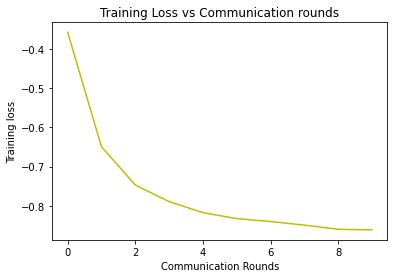

In [26]:
%matplotlib inline
plt.figure()
plt.title('Training Loss vs Communication rounds')
plt.plot(range(len(train_loss)), train_loss, color='y')
plt.ylabel('Training loss')
plt.xlabel('Communication Rounds')
plt.show()

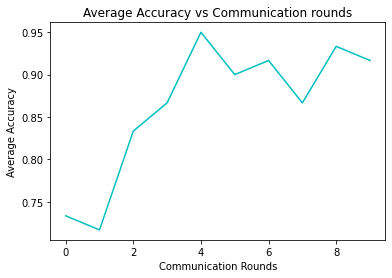

In [27]:
%matplotlib inline
plt.figure()
plt.title('Average Accuracy vs Communication rounds')
plt.plot(range(len(train_accuracy)), train_accuracy, color='c')
plt.ylabel('Average Accuracy')
plt.xlabel('Communication Rounds')
plt.show()